<a href="https://colab.research.google.com/github/shashwatbahuguna/Gas_LeakTime_Prediction_NN/blob/main/ME504DLPS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, Model
import keras
from keras.regularizers import l2

# For Ordinal Encoding and standardising of the input
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
encoder = OrdinalEncoder()


# For recording history MSE values
from keras.callbacks import History 

In [ ]:
# Total dataset imported
dataset_total = pd.read_csv("ME504 ProcessedFinalData.csv", usecols=["Service Time(Years)", "MF_INVOLVED_TEXT", "LEAK_LOCATION_A_TEXT", "LEAK_LOCATION_B_TEXT", "LEAK_LOCATION_C_TEXT", "FITTING_MATERIAL_TEXT", "PIPE - 1 MATERIAL",	"PIPE - 2 MATERIAL",	"CAUSE OF LEAK", "LEAK_OCCURRED_TEXT", "PIPE - 1 DIA",	"PIPE - 2 DIA", "MF_TYPE_TEXT" ])
dataset_total = dataset_total[dataset_total["Service Time(Years)"] != 0]
dataset_total.head()

,PIPE - 1 DIA,PIPE - 2 DIA,Service Time(Years),FITTING_MATERIAL_TEXT,PIPE - 1 MATERIAL,PIPE - 2 MATERIAL,MF_INVOLVED_TEXT,MF_TYPE_TEXT,LEAK_LOCATION_A_TEXT,LEAK_LOCATION_B_TEXT,LEAK_LOCATION_C_TEXT,CAUSE OF LEAK,LEAK_OCCURRED_TEXT
48,8.0,4.0,1,STEEL,PLASTIC,PLASTIC,BOLTED,COUPLING,BELOWGROUND,OUTSIDE,MAIN-TO-MAIN,OTHER,LEAKED THROUGH SEAL
49,8.0,6.0,1,COMBINATION PLASTIC AND STEEL,PLASTIC,PLASTIC,NUT FOLLOWER,COUPLING,BELOWGROUND,OUTSIDE,SERVICE-TO-SERVICE,INCORRECT OPERATION,PULLED OUT
50,8.0,6.0,1,PLASTIC,PLASTIC,PLASTIC,OTHER COMPRESSION TYPE FITTING,COUPLING,BELOWGROUND,OUTSIDE,SERVICE-TO-SERVICE,INCORRECT OPERATION,LEAKED THROUGH SEAL
51,8.0,6.0,1,PLASTIC,PLASTIC,PLASTIC,NUT FOLLOWER,VALVE,BELOWGROUND,OUTSIDE,SERVICE-TO-SERVICE,INCORRECT OPERATION,LEAKED THROUGH SEAL
52,8.0,6.0,1,PLASTIC,PLASTIC,PLASTIC,STAB,RISER,ABOVEGROUND,OUTSIDE,SERVICE-TO-SERVICE,OTHER OUTSIDE FORCE DAMAGE,LEAKED THROUGH BODY


In [ ]:
# Separating Output Feature
Y_num = dataset_total[["Service Time(Years)"]].copy()
Y_num.head()

,Service Time(Years)
48,1
49,1
50,1
51,1
52,1


In [ ]:
# Separating Input Variables
X = dataset_total[["MF_INVOLVED_TEXT",  "MF_TYPE_TEXT", "PIPE - 1 DIA", "PIPE - 2 DIA",  "PIPE - 1 MATERIAL",	"PIPE - 2 MATERIAL", "FITTING_MATERIAL_TEXT"]].copy() #"Altitude (m)", 
X.head()

,MF_INVOLVED_TEXT,MF_TYPE_TEXT,PIPE - 1 DIA,PIPE - 2 DIA,PIPE - 1 MATERIAL,PIPE - 2 MATERIAL,FITTING_MATERIAL_TEXT
48,BOLTED,COUPLING,8.0,4.0,PLASTIC,PLASTIC,STEEL
49,NUT FOLLOWER,COUPLING,8.0,6.0,PLASTIC,PLASTIC,COMBINATION PLASTIC AND STEEL
50,OTHER COMPRESSION TYPE FITTING,COUPLING,8.0,6.0,PLASTIC,PLASTIC,PLASTIC
51,NUT FOLLOWER,VALVE,8.0,6.0,PLASTIC,PLASTIC,PLASTIC
52,STAB,RISER,8.0,6.0,PLASTIC,PLASTIC,PLASTIC


In [ ]:
# Numerical Component of Input Variables
X_num  = X[["PIPE - 1 DIA"	,"PIPE - 2 DIA"]]
X_num.head()


# Standardizing Numerical Input Features
ss = StandardScaler()
X_num_std = ss.fit_transform(X_num)

In [ ]:
# Categorical Component of Input Variables
X_cat = X[["MF_INVOLVED_TEXT", "MF_TYPE_TEXT", "PIPE - 1 MATERIAL"	,"PIPE - 2 MATERIAL",	"FITTING_MATERIAL_TEXT"]].copy()
X_cat.head()

# Ordinal Encoding (Integers from 1 to n alloted to each Category) For Categorical Inputs (For Embedding Layer)
X_cat_enc = encoder.fit_transform(X_cat)

In [ ]:
# For Counting no. of Different Categories to determine Embedding Layer Size
X_cat.value_counts()

MF_INVOLVED_TEXT                MF_TYPE_TEXT         PIPE - 1 MATERIAL  PIPE - 2 MATERIAL  FITTING_MATERIAL_TEXT        
NUT FOLLOWER                    COUPLING             STEEL              STEEL              STEEL                            859
BOLTED                          COUPLING             STEEL              STEEL              STEEL                            346
STAB                            COUPLING             PLASTIC            PLASTIC            PLASTIC                          341
NUT FOLLOWER                    COUPLING             STEEL              PLASTIC            STEEL                            333
                                SERVICE OR MAIN TEE  STEEL              STEEL              STEEL                            299
                                                                                                                           ... 
OTHER COMPRESSION TYPE FITTING  ADAPTER              COPPER             COPPER             COMBINATION PLASTIC 

In [ ]:
# DEFINING THE MODEL


# Input Layers (4 for Categorical, 4 for numerical Input)
num_inputs = tf.keras.layers.Input((X_num.shape[1],  ), name = "num_input")

cat_inputs_a = tf.keras.layers.Input((1,  ), name = "cat_input_a")
cat_inputs_b = tf.keras.layers.Input((1,  ), name = "cat_input_b")
cat_inputs_c = tf.keras.layers.Input((1,  ), name = "cat_input_c")
cat_inputs_d = tf.keras.layers.Input((1,  ), name = "cat_input_d")
cat_inputs_e = tf.keras.layers.Input((1,  ), name = "cat_input_e")


# Embedding Layers Correcspoding to Each Feature  (Size for layers, Output features is Hard Coded As per Post-Processing Data)
cat_proc_a = tf.keras.layers.Embedding(7, 6, input_length = X_cat_enc.shape[1])(cat_inputs_a)
cat_proc_b = tf.keras.layers.Embedding(9, 8, input_length = X_cat_enc.shape[1])(cat_inputs_b)
cat_proc_c = tf.keras.layers.Embedding(9, 5, input_length = X_cat_enc.shape[1])(cat_inputs_c)
cat_proc_d = tf.keras.layers.Embedding(12, 11, input_length = X_cat_enc.shape[1])(cat_inputs_d)
cat_proc_e = tf.keras.layers.Embedding(12, 11, input_length = X_cat_enc.shape[1])(cat_inputs_e)

# Flattening the Output Tf Vector for Each layer for concatenation at later stage 
cat_proc_a = tf.keras.layers.Flatten()(cat_proc_a)
cat_proc_b = tf.keras.layers.Flatten()(cat_proc_b)
cat_proc_c = tf.keras.layers.Flatten()(cat_proc_c)
cat_proc_d = tf.keras.layers.Flatten()(cat_proc_d)
cat_proc_e = tf.keras.layers.Flatten()(cat_proc_e)


# Conctenating Embedding Layer Outputs with Numerical Inputs
x = tf.keras.layers.Concatenate( axis = -1)([num_inputs, cat_proc_a, cat_proc_b, cat_proc_c, cat_proc_d, cat_proc_e])


# SEQUENCTIAL MODEL POST COMPILING DIFFERNET INPUTS

x = tf.keras.layers.Dense(10, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)           # DropOut Layer to Minimize Overfitting
x = tf.keras.layers.BatchNormalization()(x)  # Batch Normalization

x = tf.keras.layers.Dense(8, kernel_regularizer=l2(0.01) ,activation = 'relu')(x)   # Dense Layer with Weight Decay Enabled
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(9, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)      # DropOut Layer
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(5, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(7, kernel_regularizer=l2(0.05),activation = 'relu')(x)   # Weight Decay Enabled
x = tf.keras.layers.BatchNormalization()(x)

output = tf.keras.layers.Dense(Y_num.shape[1], activation = 'relu', name = 'output')(x)

In [ ]:
# Compiling the Model and Resetting History
modelN = tf.keras.models.Model(
    inputs = [num_inputs, cat_inputs_a, cat_inputs_b, cat_inputs_c, cat_inputs_d, cat_inputs_e], 
    outputs = output)
modelN.compile(optimizer = keras.optimizers.Adam(lr = 0.0005),
               loss = "mse",
               metrics = [tf.keras.losses.MeanAbsolutePercentageError()])

# Resetting History
modelN.summary()
history = History()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_input_a (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_input_b (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_input_c (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_input_d (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
# Fitting the model with spliced Categorical Inputs(Separated into 4) and Numerical Inputs
modelN.fit([ X_num_std, X_cat_enc[:, 0].reshape(-1, 1), X_cat_enc[:, 1].reshape(-1, 1), X_cat_enc[:, 2].reshape(-1, 1), X_cat_enc[:, 3].reshape(-1, 1), X_cat_enc[:, 4].reshape(-1, 1)],
           Y_num, batch_size= 10, epochs = 40, 
           validation_split=0.2,
           callbacks=[history]
           )

Epoch 1/40
957/957 [==============================] - 2s 2ms/step - loss: 30.7865 - mean_absolute_percentage_error: 29.1821 - val_loss: 310.5558 - val_mean_absolute_percentage_error: 21.0165
Epoch 2/40
957/957 [==============================] - 2s 2ms/step - loss: 28.5947 - mean_absolute_percentage_error: 29.1669 - val_loss: 351.8143 - val_mean_absolute_percentage_error: 23.2062
Epoch 3/40
957/957 [==============================] - 2s 2ms/step - loss: 29.4620 - mean_absolute_percentage_error: 28.5427 - val_loss: 305.2406 - val_mean_absolute_percentage_error: 20.9671
Epoch 4/40
957/957 [==============================] - 2s 2ms/step - loss: 29.7052 - mean_absolute_percentage_error: 29.2113 - val_loss: 356.3226 - val_mean_absolute_percentage_error: 23.3090
Epoch 5/40
957/957 [==============================] - 2s 2ms/step - loss: 29.2145 - mean_absolute_percentage_error: 29.6142 - val_loss: 308.6469 - val_mean_absolute_percentage_error: 21.2340
Epoch 6/40
957/957 [=========================

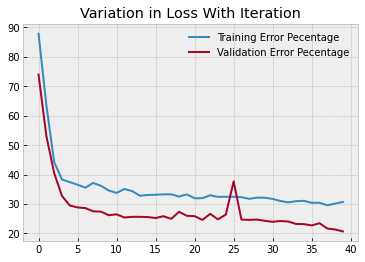

In [ ]:
# MSE History Plot (Training Vs. Validation)
plt.style.use('bmh')
plt.plot(history.history['mean_absolute_percentage_error'], label =  "Training Error Pecentage")
plt.plot(history.history['val_mean_absolute_percentage_error'], label =  "Validation Error Pecentage")
plt.legend(loc='upper right', frameon = False)
plt.title("Variation in Loss With Iteration")
plt.show()

In [ ]:
history.history

{'loss': [838.9046020507812,
  379.9729309082031,
  157.6910858154297,
  91.23822021484375,
  75.43634796142578,
  68.73660278320312,
  67.0241470336914,
  65.00403594970703,
  63.293148040771484,
  60.35733413696289,
  56.65998458862305,
  59.2598762512207,
  57.73496627807617,
  54.660160064697266,
  53.38275909423828,
  53.463523864746094,
  52.39620590209961,
  54.64125442504883,
  49.42412567138672,
  43.49259567260742,
  39.2794189453125,
  36.998779296875,
  37.014732360839844,
  34.68624496459961,
  34.73918151855469,
  35.056190490722656,
  34.23772430419922,
  33.09466552734375,
  34.003883361816406,
  34.089088439941406,
  32.629756927490234,
  31.984249114990234,
  32.1790657043457,
  33.16917037963867,
  32.50304412841797,
  32.134620666503906,
  31.344635009765625,
  30.201751708984375,
  30.43303871154785,
  31.065643310546875],
 'mean_absolute_percentage_error': [87.8508529663086,
  63.66433334350586,
  44.3204231262207,
  38.330650329589844,
  37.468971252441406,
  36.

In [ ]:
history.history

{'loss': [838.9046020507812,
  379.9729309082031,
  157.6910858154297,
  91.23822021484375,
  75.43634796142578,
  68.73660278320312,
  67.0241470336914,
  65.00403594970703,
  63.293148040771484,
  60.35733413696289,
  56.65998458862305,
  59.2598762512207,
  57.73496627807617,
  54.660160064697266,
  53.38275909423828,
  53.463523864746094,
  52.39620590209961,
  54.64125442504883,
  49.42412567138672,
  43.49259567260742,
  39.2794189453125,
  36.998779296875,
  37.014732360839844,
  34.68624496459961,
  34.73918151855469,
  35.056190490722656,
  34.23772430419922,
  33.09466552734375,
  34.003883361816406,
  34.089088439941406,
  32.629756927490234,
  31.984249114990234,
  32.1790657043457,
  33.16917037963867,
  32.50304412841797,
  32.134620666503906,
  31.344635009765625,
  30.201751708984375,
  30.43303871154785,
  31.065643310546875],
 'mean_absolute_percentage_error': [87.8508529663086,
  63.66433334350586,
  44.3204231262207,
  38.330650329589844,
  37.468971252441406,
  36.

In [ ]:
history.history

{'loss': [838.9046020507812,
  379.9729309082031,
  157.6910858154297,
  91.23822021484375,
  75.43634796142578,
  68.73660278320312,
  67.0241470336914,
  65.00403594970703,
  63.293148040771484,
  60.35733413696289,
  56.65998458862305,
  59.2598762512207,
  57.73496627807617,
  54.660160064697266,
  53.38275909423828,
  53.463523864746094,
  52.39620590209961,
  54.64125442504883,
  49.42412567138672,
  43.49259567260742,
  39.2794189453125,
  36.998779296875,
  37.014732360839844,
  34.68624496459961,
  34.73918151855469,
  35.056190490722656,
  34.23772430419922,
  33.09466552734375,
  34.003883361816406,
  34.089088439941406,
  32.629756927490234,
  31.984249114990234,
  32.1790657043457,
  33.16917037963867,
  32.50304412841797,
  32.134620666503906,
  31.344635009765625,
  30.201751708984375,
  30.43303871154785,
  31.065643310546875],
 'mean_absolute_percentage_error': [87.8508529663086,
  63.66433334350586,
  44.3204231262207,
  38.330650329589844,
  37.468971252441406,
  36.

In [ ]:
Y_pred = modelN.predict([ X_num_std, X_cat_enc[:, 0].reshape(-1, 1), X_cat_enc[:, 1].reshape(-1, 1), X_cat_enc[:, 2].reshape(-1, 1), X_cat_enc[:, 3].reshape(-1, 1), X_cat_enc[:, 4].reshape(-1, 1)])

##----------------------------------------------------------------------END--------------------------------------------------------------------------------
#### (Predicted Values printed Ahead)

In [ ]:
print(Y_pred[:, 0])

[ 8.5731   11.092233 10.902715 ...  0.        0.        0.      ]


In [ ]:
Y_num.values[:, 0]

array([  0,   0,   0, ..., 132, 148, 149])

In [ ]:
from google.colab import files
files.download(".checkpoint")

FileNotFoundError: ignored